# ANALIZKA ILOŚCI KOMENATRZY cz 1 weekend

## Scrapowanie i twierzenie tabeli

Zamieszczam tu wszystkie potrzebne biblioteki,tak aby znajwowały się w jednym miejscu.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import datetime
import time as ti
from scipy import stats
import os

# do wykresów
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
matplotlib.style.use('ggplot')

Teraz wchodzę na sronę horkruks i scrapuje linki do jej starczych postów.

In [2]:
strony = []
page = 'https://www.horkruks.com/'
url = requests.get(page)
code = BeautifulSoup(url.text, "html.parser")
lista = code.findAll("div", {"id": "BlogArchive1_ArchiveList"})
lista = lista[0].findAll("option")
for http in lista:
    strony.append(re.sub("'", "", str(http['value'])))
# pierwszy link jest pusty dlatego go odrzucamy
strony = pd.Series(strony)
strony = strony.drop([0])

strony.to_csv('lista_linkow_horkruks')

Teraz wykorzystuję pozyskane linki, aby uzyskać informacje na temat dnia opublikowania każdego postu.

In [3]:
comments = [] # ilość komenatrzy
menu = [] # data publikacji
for item in strony:
    url = requests.get(item)
    code = BeautifulSoup(url.text, "html.parser")
    menu = menu + (list(code.findAll("abbr", {"class": "published"})))
    comments = comments + (list(code.findAll("a", {"class": "comment-link"})))
menu = pd.Series(menu)
comments = pd.Series(comments)

In [4]:
print("Mamy teraz {} opublikowanych postów.".format(menu.count()))

Mamy teraz 1060 opublikowanych postów.


Teraz pobieramy poszczególne dane. Zaczynamy od ustalenia dnia, miesiąca oraz roku opublikowania.

In [5]:
date_list = []
lista = menu
for item in lista:
    it = (str(item).split())[2]
    it = re.sub("[^0-9]", "-", it)
    it = it.split("-")
    
    for ex in it:
        if (str(ex)) != '':
            date_list.append(ex)
            
year = []
mounth = []
day = []
for i in range(0, int(len(date_list)/10)): #dzielimy przez 10 nie tylko data to cyfry
    year.append(date_list[i*10])
    mounth.append(date_list[i*10+1])
    day.append(date_list[i*10+2])
    
date = pd.DataFrame({"rok":year,
                     "miesiac":mounth,
                     "dzien":day
                    })

Sprawdzam czy dany dzień był weekendem czy dniem powszednim.

In [6]:
full_date = []
times = []
weekend = []
today = datetime.date.today()
for i in range(0, len(date.rok)):
    item = datetime.date(int(date.rok[i]), int(date.miesiac[i]), int(date.dzien[i]))
    full_date.append(item)
    long = today - item
    long = str(long)
    long = long.split(",")
    long = re.sub("[^0-9]", "", long[0])
    long = int(long)
    times.append(long)
    if item.weekday() > 5:
        weekend.append(1)
    else:
        weekend.append(0)
        
date['weekend'] = pd.Categorical(weekend) #bo to będzie przedmiotem naszego badania, czy weekend ma wpływ na popularnosc
date['starosc'] = pd.Series(times, index = date.index)

Mamy teraz niemalże gotową tabelę.

In [7]:
date.head()

,rok,miesiac,dzien,weekend,starosc
0,2019,07,25,0,2
1,2019,07,13,0,14
2,2019,07,12,0,15
3,2019,06,12,0,45
4,2019,06,12,0,45


In [8]:
comments_pure = []
for it in comments:
    comments_pure.append(int(re.sub("[^0-9]", "", it.text)))
    
comments_pure = pd.Series(comments_pure)
comments_pure = comments_pure.drop([0]) # wyrzucamy ten pierwszy do ktorego link był pusty
    
date['komentarze'] = pd.Series(comments_pure, index = date.index)

Teraz pozbywamy sie tych wartosci, o których nie wiemy jaka jest ich liczba komentarzy.

In [9]:
date = date.dropna()

Uzyskaliśmy w ten sposób następującą liczbę postów opulikowanych w weekend oraz tych w dni powszednie. Następnie przestawiamy je na wykresie.

In [10]:
date['weekend'].value_counts()

0    935
1    123
Name: weekend, dtype: int64

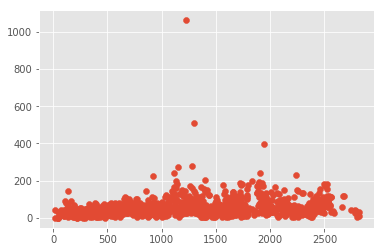

In [11]:
plt.scatter(date['starosc'], date['komentarze'])
plt.show()

Usuwamy więc wartości odstające aby uzyskać lepsze wyniki analizy.

In [12]:
date = date.loc[(date['komentarze'] < 250)]

Ponownie wykonujemy wykres.

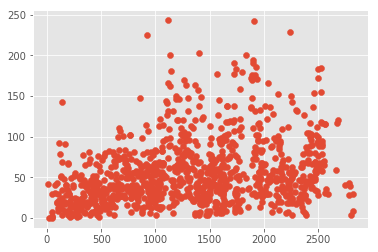

In [13]:
plt.scatter(date['starosc'], date['komentarze'])
plt.show()

Teraz sprawdzamy korelacje poszczególnych czynników. Jakie jest ich wpływ na ilość komentarzy.

Dzielimy naszą grupę na dwie tabele. 

In [14]:
week_days = date.loc[date['weekend']==0]
weekend_days = date.loc[date['weekend']==1]

Sprawdzamy normanlość rozkładu poszczególnych grup. Używamy do tego testu Shapiro-Wilka. Badaną cehcą jest ilość komentarzy.
## Ho - rozkład normalny 
## H1 - rozkład nie jest normalny
### p-value = 0.05

In [15]:
t1, p1 = stats.shapiro(week_days['komentarze'])
t2, p2 = stats.shapiro(weekend_days['komentarze'])

In [16]:
print('Uzyskano w ten sposob wartości {} oraz {} są mniejsze od poziomu istotności. Odrzucamy więc hipotezę zerową o normalności rozkładów.'.format(p1,p2))

Uzyskano w ten sposob wartości 3.534392431710558e-25 oraz 2.993596126543707e-08 są mniejsze od poziomu istotności. Odrzucamy więc hipotezę zerową o normalności rozkładów.


Nie możemy stosować testu t-studenta. Wybierzemy więc inny test, aby sprawdzić, czy równica między grupami jest statystycznie istotna. Test Manna-Whitney’a, który zamiast równości średnich arytmetycznych, sprawdza równość rang.
 
## Ho - identyczne grupy 
## H1 - grupy różne

### p-value = 0.05

In [17]:
t3, p3 = stats.mannwhitneyu(weekend_days['komentarze'],week_days['komentarze'])

In [18]:
print("Wielkość {} jest większa od p-value, nie ma podstaw do potwierdzenia, że grupy nie są identyczne".format(p3))

Wielkość 0.487037928458355 jest większa od p-value, nie ma podstaw do potwierdzenia, że grupy nie są identyczne


Wizuwalizujemy to zjawisko.


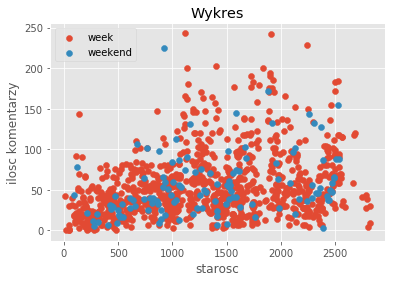

In [19]:
plt.scatter(week_days['starosc'], week_days['komentarze'], label='week')
plt.scatter(weekend_days['starosc'], weekend_days['komentarze'], label='weekend')

plt.xlabel('starosc')
plt.ylabel('ilosc komentarzy')

plt.title("Wykres")

plt.legend()

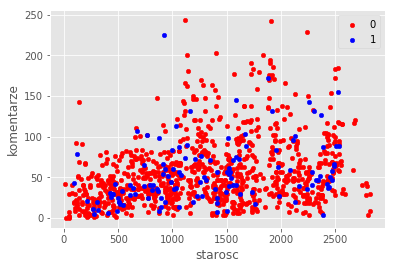

In [20]:
fig, ax = plt.subplots()
grouped = date.groupby('weekend')
colors= {0:'red', 1:'blue'}
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='starosc', y='komentarze', label=key, color=colors[key])
#plt.show()
#plt.scatter(grouped['starosc'], grouped['komentarze'])

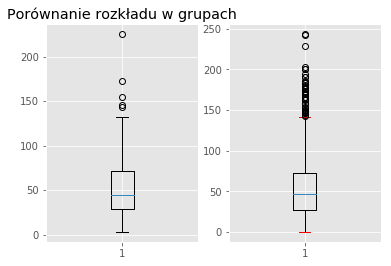

In [21]:
plt.subplot(1, 2, 1)
plt.boxplot(weekend_days['komentarze'])
plt.title('Porównanie rozkładu w grupach')
plt.xlabel('')

plt.subplot(1,2,2)
plt.boxplot(week_days['komentarze'], capprops=dict(color='red'), flierprops=dict(color='red'))
plt.xlabel('')
plt.ylabel('')

plt.show()
#to powinno być inaczej, ale widać, że się pokrywają

Powyższe wykresy wskazują iż rzeczywiście rozkład w obu grupach jest taki sam.

# Można więc wywnioskować, że to czy dany post był opublikowany w weekend czy w zwykły dzień tygodnia, nie skutkowało inną ilością komentarzy.

sciezka = "Jupiter/HORKRUKS_BLOG_BADANIE"
sciezka = os.path.join("C:","Users", "Edyta", "Desktop", str(sciezka))
try:
    with open(sciezka, "w") as wiersz:
        wiersz.writelines

Zapisuje teraz swoja tabelke jako plik csv

In [ ]:
sciezka = os.path.join("C:","Users", "Edyta", "Desktop")
sciezka = "C:/Users/Edyta/Desktop/Jupiter/Ed"
date.to_csv(sciezka)

Aby lepiej segregować dane obrazy (aby wiedzieć dokładnie z jakiego posta pochodzą) musimy scrappować stronę jeszcze raz tym razem innymi metodami. Dlatego dalsza część analizy jest zawarta w innym zeszycie.

